In [62]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the data

In [63]:
with open("data/liam.json") as f:
    data = json.load(f)

# Explore the structure of the data

In [64]:
data.keys()

dict_keys(['bone_list', 'frames', 'joint_names', 'k4abt_sdk_version', 'source_file'])

In [65]:
data["source_file"]  # Just the path of the source file

'D:\\CSI Depth Camera\\Data\\Run1\\Clap\\RX.mkv'

In [66]:
data["joint_names"][0] # Example of joint name

'PELVIS'

In [67]:
n_joints = len(data["joint_names"])  # The number of joints
n_joints

32

In [68]:
len(data["bone_list"])

31

In [69]:
bone_list = data["bone_list"]
bone_list

[['SPINE_CHEST', 'SPINE_NAVEL'],
 ['SPINE_NAVEL', 'PELVIS'],
 ['SPINE_CHEST', 'NECK'],
 ['NECK', 'HEAD'],
 ['HEAD', 'NOSE'],
 ['SPINE_CHEST', 'CLAVICLE_LEFT'],
 ['CLAVICLE_LEFT', 'SHOULDER_LEFT'],
 ['SHOULDER_LEFT', 'ELBOW_LEFT'],
 ['ELBOW_LEFT', 'WRIST_LEFT'],
 ['WRIST_LEFT', 'HAND_LEFT'],
 ['HAND_LEFT', 'HANDTIP_LEFT'],
 ['WRIST_LEFT', 'THUMB_LEFT'],
 ['PELVIS', 'HIP_LEFT'],
 ['HIP_LEFT', 'KNEE_LEFT'],
 ['KNEE_LEFT', 'ANKLE_LEFT'],
 ['ANKLE_LEFT', 'FOOT_LEFT'],
 ['NOSE', 'EYE_LEFT'],
 ['EYE_LEFT', 'EAR_LEFT'],
 ['SPINE_CHEST', 'CLAVICLE_RIGHT'],
 ['CLAVICLE_RIGHT', 'SHOULDER_RIGHT'],
 ['SHOULDER_RIGHT', 'ELBOW_RIGHT'],
 ['ELBOW_RIGHT', 'WRIST_RIGHT'],
 ['WRIST_RIGHT', 'HAND_RIGHT'],
 ['HAND_RIGHT', 'HANDTIP_RIGHT'],
 ['WRIST_RIGHT', 'THUMB_RIGHT'],
 ['PELVIS', 'HIP_RIGHT'],
 ['HIP_RIGHT', 'KNEE_RIGHT'],
 ['KNEE_RIGHT', 'ANKLE_RIGHT'],
 ['ANKLE_RIGHT', 'FOOT_RIGHT'],
 ['NOSE', 'EYE_RIGHT'],
 ['EYE_RIGHT', 'EAR_RIGHT']]

In [70]:
n_frames = len(data["frames"])  # The number of frames

In [71]:
joint_names = data["joint_names"]
joint_names

['PELVIS',
 'SPINE_NAVEL',
 'SPINE_CHEST',
 'NECK',
 'CLAVICLE_LEFT',
 'SHOULDER_LEFT',
 'ELBOW_LEFT',
 'WRIST_LEFT',
 'HAND_LEFT',
 'HANDTIP_LEFT',
 'THUMB_LEFT',
 'CLAVICLE_RIGHT',
 'SHOULDER_RIGHT',
 'ELBOW_RIGHT',
 'WRIST_RIGHT',
 'HAND_RIGHT',
 'HANDTIP_RIGHT',
 'THUMB_RIGHT',
 'HIP_LEFT',
 'KNEE_LEFT',
 'ANKLE_LEFT',
 'FOOT_LEFT',
 'HIP_RIGHT',
 'KNEE_RIGHT',
 'ANKLE_RIGHT',
 'FOOT_RIGHT',
 'HEAD',
 'NOSE',
 'EYE_LEFT',
 'EAR_LEFT',
 'EYE_RIGHT',
 'EAR_RIGHT']

In [72]:
frame0 = data["frames"][0]

In [73]:
frame0.keys()

dict_keys(['bodies', 'frame_id', 'num_bodies', 'timestamp_usec'])

In [74]:
frame0["bodies"][0].keys()  # There are as much "bodies" as people in the scene

dict_keys(['body_id', 'joint_orientations', 'joint_positions'])

# Static plot

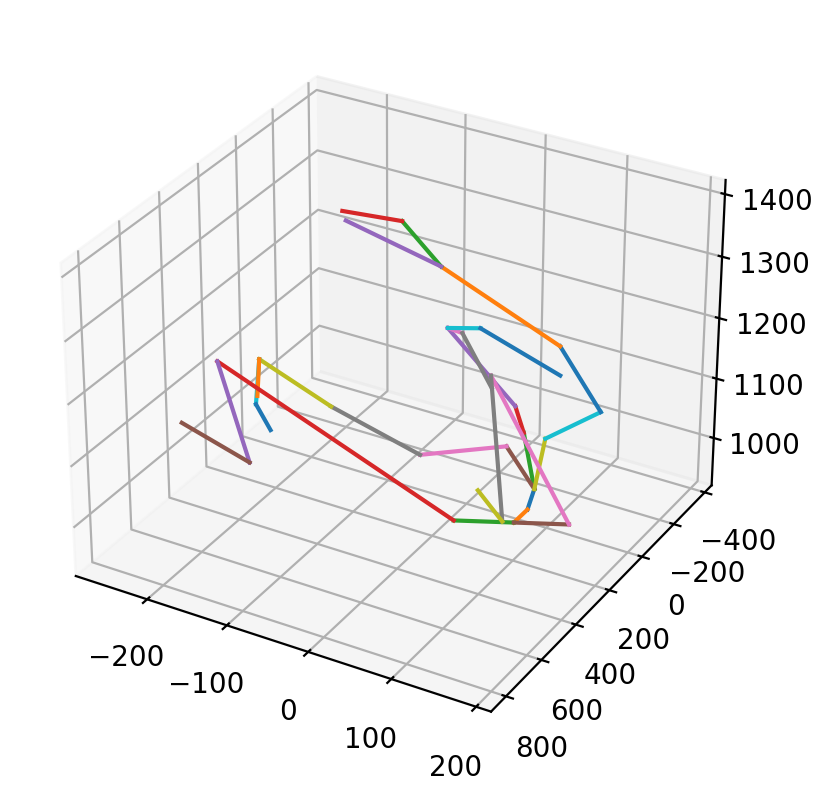

In [80]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.invert_yaxis()
frame_id = 0
body_id = 0
joint_pos = data["frames"][frame_id]["bodies"][body_id]["joint_positions"]
for bone in bone_list:
    idx_joint_0 = joint_names.index(bone[0])
    idx_joint_1 = joint_names.index(bone[1])
    ax.plot([joint_pos[idx_joint_0][0], joint_pos[idx_joint_1][0]],
            [joint_pos[idx_joint_0][1], joint_pos[idx_joint_1][1]],
            [joint_pos[idx_joint_0][2], joint_pos[idx_joint_1][2]])

# Animated plot

### Find the range of the data

In [78]:
range_val = np.zeros((3, 2))
range_val[:, 0] = np.inf
range_val[:, 1] = -np.inf
body_id = 0
for frame in data["frames"]:
    joint_pos = frame["bodies"][body_id]["joint_positions"]
    for idx_joint in range(n_joints):
        for idx_coord in range(3):
            range_val[idx_coord, 0] = min(range_val[idx_coord, 0], joint_pos[idx_joint][idx_coord])
            range_val[idx_coord, 1] = max(range_val[idx_coord, 1], joint_pos[idx_joint][idx_coord])

In [79]:
n_frames

6322

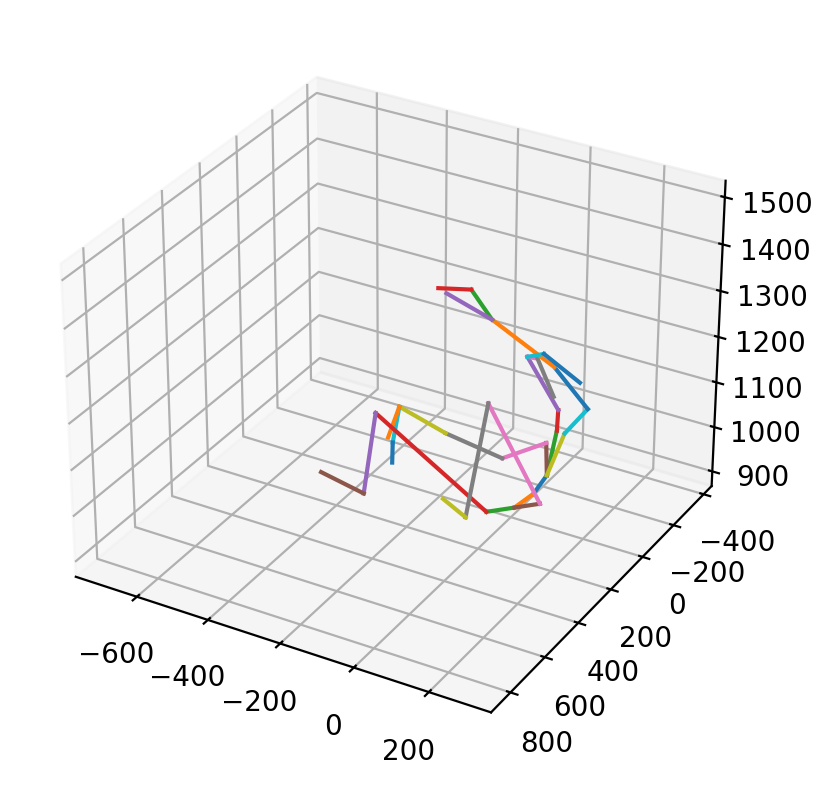

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

n_anim_frames = 10  # The number of animation frames
frame_delta = 100  # How many frames between each animation frame

assert frame_delta * n_anim_frames < n_frames

def animate(i):
    ax.clear()
    ax.axis(range_val.flatten())
    ax.invert_yaxis()
    frame_id = frame_delta * i
    
    joint_pos = data["frames"][frame_id]["bodies"][body_id]["joint_positions"]
    for bone in bone_list:
        idx_joint_0 = joint_names.index(bone[0])
        idx_joint_1 = joint_names.index(bone[1])
        
        ax.plot([joint_pos[idx_joint_0][0], joint_pos[idx_joint_1][0]],
                [joint_pos[idx_joint_0][1], joint_pos[idx_joint_1][1]],
                [joint_pos[idx_joint_0][2], joint_pos[idx_joint_1][2]])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=n_anim_frames)

from IPython.display import HTML
HTML(ani.to_jshtml())